Specify Project root and load dataset

In [ ]:
import sys, os

# Path to your project root (adjust if different)
project_root = os.path.expanduser("~/vg-influence-project")

if project_root not in sys.path:
    sys.path.append(project_root)

print(project_root in sys.path)  # should print True


True


In [3]:
from datasets import load_dataset
from transformers import CLIPModel, CLIPProcessor
from src.refcoco_dataset import RefCOCODataset
from src.features import crop_image, encode_pair
import matplotlib.pyplot as plt
ds = load_dataset("moondream/refcoco-m")
print(ds)

DatasetDict({
    validation: Dataset({
        features: ['image', 'image_id', 'file_name', 'samples'],
        num_rows: 1190
    })
})


In [4]:
print(ds.keys())
base_split = ds["validation"]
print(base_split[0])

dict_keys(['validation'])
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x294 at 0x78A4CD11BFE0>, 'image_id': 458827, 'file_name': 'COCO_train2014_000000458827.jpg', 'samples': [{'id': 424581, 'image_id': 458827, 'category': 'person', 'supercategory': 'person', 'label': None, 'sentences': ['left guy', 'person on left', 'left person'], 'bbox': [13.210000038146973, 1.1200000047683716, 183.6699981689453, 260.9700012207031], 'mask': {'counts': 'gk39j86L3L4L3M2N3N2M3M5K5K9F9\\Om0ZO=F7I6L3M2M4M2M3N2N1O2M3N101N10001O00000001iN_KTM11`4l2aKnL42]4o2VLkLl3[2ZKiM10h5U2l0L3O1N200O10000O1O2N1O2O00jNSNSKo1m4SNoJn1R5RNfJV2Z5kMbJW2_5jM^JW2c5jM[JV2f5kMXJV2h5kMWJT2j5mMTJT2l5mMSJR2n5QNnIo1S6b00O100O1O100O1O100O1O100O10000O100O10000O10000O100001O1O2N1O3M2N3M2N2N2N3M2N2N3M2N3M3M3M2N3M3M3M2N3M3M3M3M2N4L2N3M2N2N2N3M2N3M3M2N3M3M4L3M4L3M2N3M3M2N1O1O000000001O00lIoMT1IQ2X2fLVN`0^OB?Q3m1kLYN`0a0b2V1mL]N<c0c2P1oLcN8h0`2e0WMR1f2nNZMT1d2lN\\MV1i2cNWM^1l2^NTMc1o2YNQMk1l2TNTMP2i2oMVMT2k2iMUMY2m2cMSM

Make train / val split since the dataset only ships with one split

In [5]:
from datasets import load_dataset
ds = load_dataset("moondream/refcoco-m")
base = ds["validation"]  # the only split they give

# Create train/val split (80/20)
split = base.train_test_split(test_size=0.2, seed=42) # test_size means validation here, seed means random seed
train_split = split["train"]
val_split = split["test"]

train_ds = RefCOCODataset(train_split)
len(train_ds), train_ds[0]["phrase"], train_ds[0]["bbox"]

# print("train split:", len(train_split), "\n", "val split:", len(val_split))
# print(train_split[0])

(4508, 'left guy', [20.790000915527344, 61.75, 211.12000274658203, 480.0])

Visually Confirm the crop of the bounding box

(-0.5, 190.5, 418.5, -0.5)

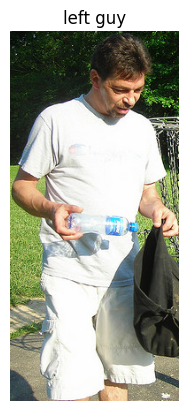

In [6]:
ex = train_ds[0]
crop = crop_image(ex["image"], ex["bbox"])

plt.imshow(crop)
plt.title(ex["phrase"])
plt.axis("off")


Implement CLIP multimodal encoder

In [7]:
import numpy as np
from transformers import CLIPProcessor, CLIPModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

X_list = []
y_list = []
for i in range(10): # first 10 *positive* examples
    ex = train_ds[i]
    image_crop = crop_image(ex["image"], ex["bbox"])
    feat = encode_pair(image_crop, ex["phrase"], clip_model, clip_processor, device)
    X_list.append(feat)
    y_list.append(1)  # all positive for now

X = np.stack(X_list)
y = np.array(y_list)

print("X shape:", X.shape)
print("y:", y)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


X shape: (10, 1024)
y: [1 1 1 1 1 1 1 1 1 1]


In [ ]:
def build_positive_only_dataset(ref_ds, model, processor, device, max_examples=10):
    """
    ref_ds      : RefCOCODataset
    model       : CLIP model
    processor   : CLIP processor
    device      : torch.device
    max_examples: cap on how many ref_ds items to use
    Returns: X (N, d), y (N,)
    """
    X_list = []
    y_list = []
    for i in range (min(max_examples, len(ref_ds))):
        ex = ref_ds[i]
        img = ex["image"]
        phrase = ex["phrase"]
        bbox = ex["bbox"]
        image_crop = crop_image(img, bbox)
        feat = encode_pair(image_crop, phrase, model, processor, device)
        X_list.append(feat)
        y_list.append(1)
    X = np.array(X_list)
    y = np.array(y_list)
    return X, y

X_pos, y_pos = build_positive_only_dataset(train_ds, clip_model, clip_processor, device, max_examples=5)
print("X_pos shape:", X_pos.shape)
print("y_pos:", y_pos)

X_pos shape: (5, 1024)
y_pos: [1 1 1 1 1]


Extend it to include negatives (build full binary dataset)

In [ ]:
def build_binary_dataset(ref_ds, model, processor, device,
                         max_examples=100, neg_per_pos=2):
    """
    Returns X, y where:
      - for each ref_ds[i] you create 1 positive (label 1)
      - and neg_per_pos negatives (label 0) from random boxes on the same image
    """
    X_list = []
    y_list = []
    for i in range (min(max_examples, len(ref_ds))):
        ex = ref_ds[i]
        img = ex["image"]
        phrase = ex["phrase"]
        bbox = ex["bbox"]
        # Positive example
        image_crop = crop_image(img, bbox)
        feat_pos = encode_pair(image_crop, phrase, model, processor, device)
        X_list.append(feat_pos)
        y_list.append(1)
        # Negative examples
        img_width, img_height = img.size
        box_width = bbox[2] - bbox[0]
        box_height = bbox[3] - bbox[1]
        for _ in range(neg_per_pos):
            x_min = np.random.randint(0, img_width - box_width + 1)
            y_min = np.random.randint(0, img_height - box_height + 1)
            neg_bbox = [x_min, y_min, x_min + box_width, y_min + box_height]
            neg_image_crop = crop_image(img, neg_bbox)
            feat_neg = encode_pair(neg_image_crop, phrase, model, processor, device)
            X_list.append(feat_neg)
            y_list.append(0)
    X = np.array(X_list)
    y = np.array(y_list)
    return X, y

X_small, y_small = build_binary_dataset(train_ds, clip_model, clip_processor, device,
                                        max_examples=10, neg_per_pos=2)
print("X_small shape:", X_small.shape)
print("y_small[:10]:", y_small[:10])  


X_small shape: (30, 1024)
y_small[:10]: [1 0 0 1 0 0 1 0 0 1]


Train various classifiers:
* Logistic Regression
* Random Forest
* HistGradientBoosting
Then we select the best one and train the baseline.

In [10]:
import numpy as np

# Build train/val arrays
X_train, y_train = build_binary_dataset(train_ds, clip_model, clip_processor, device,
                                        max_examples=800, neg_per_pos=2)
X_val, y_val = build_binary_dataset(RefCOCODataset(val_split), clip_model, clip_processor, device,
                                    max_examples=200, neg_per_pos=2)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score

models = {
    "logreg": LogisticRegression(max_iter=1000, n_jobs=-1),
    "rf": RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        n_jobs=-1,
        random_state=42,
    ),
    "hgb": HistGradientBoostingClassifier(
        max_depth=12,
        learning_rate=0.1,
        max_iter=200,
        random_state=42,
    ),
}

results = {}

for name, clf in models.items():
    print(f"\n=== Training {name} ===")
    clf.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, clf.predict(X_train))
    val_acc   = accuracy_score(y_val, clf.predict(X_val))

    print(f"{name} train acc: {train_acc:.3f}")
    print(f"{name} val acc:   {val_acc:.3f}")

    results[name] = {
        "clf": clf,
        "train_acc": train_acc,
        "val_acc": val_acc,
    }
    
best_name = max(results, key=lambda k: results[k]["val_acc"])
best_clf = results[best_name]["clf"]
print("Best model:", best_name, "val acc:", results[best_name]["val_acc"])



=== Training logreg ===
logreg train acc: 0.767
logreg val acc:   0.747

=== Training rf ===
rf train acc: 1.000
rf val acc:   0.665

=== Training hgb ===
hgb train acc: 1.000
hgb val acc:   0.667
Best model: logreg val acc: 0.7466666666666667


save `meta_train` and `meta_val` when building the datasets.

In [ ]:
import os, json
import torch
import numpy as np
from datasets import load_dataset
from transformers import CLIPModel, CLIPProcessor

from src.refcoco_dataset import RefCOCODataset
from src.build_binary_dataset import build_binary_dataset

os.chdir(os.path.expanduser("~/vg-influence-project"))
print("CWD:", os.getcwd())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

# HF split again
ds = load_dataset("moondream/refcoco-m")
base = ds["validation"]
split = base.train_test_split(test_size=0.2, seed=42)
train_split = split["train"]
val_split   = split["test"]

# Build binary datasets WITH metadata
X_train, y_train, meta_train = build_binary_dataset(
    train_split,
    clip_model,
    clip_processor,
    device,
    max_examples=800,
    neg_per_pos=2,
    seed=42,
)

X_val, y_val, meta_val = build_binary_dataset(
    val_split,
    clip_model,
    clip_processor,
    device,
    max_examples=200,
    neg_per_pos=2,
    seed=123,
)

print("Train:", X_train.shape, y_train.shape, " | meta_train:", len(meta_train))
print("Val:  ", X_val.shape,   y_val.shape,   " | meta_val:",   len(meta_val))



CWD: /home/oosuji/Documents/vg-influence-project


Building binary dataset: 100%|██████████| 200/200 [00:05<00:00, 39.05it/s]

Train: (2400, 1024) (2400,)  | meta_train: 2400
Val:   (600, 1024) (600,)  | meta_val: 600


In [12]:
os.makedirs("../data", exist_ok=True)

with open("../data/meta_train.json", "w") as f:
    json.dump(meta_train, f)

with open("../data/meta_val.json", "w") as f:
    json.dump(meta_val, f)


Retrain final classifier


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=1000, n_jobs=-1)
clf.fit(X_train, y_train)

print("Train acc:", accuracy_score(y_train, clf.predict(X_train)))
print("Val acc:  ", accuracy_score(y_val,   clf.predict(X_val)))


Train acc: 0.7675
Val acc:   0.74


Save the classifier with joblib so we don't have to retrain next time

In [14]:
import joblib, os
os.makedirs("../data", exist_ok=True)
joblib.dump(best_clf, "../data/logistic_regression_clip_refcoco.pkl")

['../data/logistic_regression_clip_refcoco.pkl']

influence experiment: drop some spatial training examples

* Idea: remove a small chunk of SPATIAL_ONLY training positivesand check  changes in accuracy, especially on spatial vs attribute phrases.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
from src.phrase_tags import classify_phrase_type

# import json, os
# meta_train = json.loads(open(os.path.join("data", "meta_train.json")).read())
# meta_val = json.loads(open(os.path.join("data", "meta_val.json")).read())

df_train = pd.DataFrame(meta_train)
df_val = pd.DataFrame(meta_val)

# Tag phrase types on train & val positives
df_train_pos = df_train[df_train["example_type"] == "pos"].copy()
df_train_pos["phrase_type"] = df_train_pos["phrase"].apply(classify_phrase_type)

df_val_pos = df_val[df_val["example_type"] == "pos"].copy()
df_val_pos["phrase_type"] = df_val_pos["phrase"].apply(classify_phrase_type)

# Baseline model on full training set
clf_full = LogisticRegression(max_iter=1000, n_jobs=-1)
clf_full.fit(X_train, y_train)

val_pos_idx = df_val_pos.index.to_numpy()
X_val_pos = X_val[val_pos_idx]
y_val_pos = y_val[val_pos_idx]

y_pred_full = clf_full.predict(X_val_pos)
df_val_pos["pred_full"] = y_pred_full
df_val_pos["correct_full"] = (df_val_pos["pred_full"] == y_val_pos)

print("Baseline accuracy on all positive val examples:",
      accuracy_score(y_val_pos, y_pred_full))

print("\nBaseline accuracy by phrase_type:")
print(df_val_pos.groupby("phrase_type")["correct_full"].mean())


Baseline accuracy on all positive val examples: 0.38

Baseline accuracy by phrase_type:
phrase_type
ATTRIBUTE_ONLY    0.344828
MIXED             0.500000
OTHER             0.384615
SPATIAL_ONLY      0.351648
Name: correct_full, dtype: float64


Now drop some spatial training positives and retrain:

In [16]:
# Choose a subset of SPATIAL_ONLY training positives to drop
spatial_train_pos = df_train_pos[df_train_pos["phrase_type"] == "SPATIAL_ONLY"]

print("Total SPATIAL_ONLY train positives:", len(spatial_train_pos))

# e.g., drop up to 50 spatial positives (adjust if you have fewer)
n_drop = min(50, len(spatial_train_pos))
drop_indices = spatial_train_pos.index.to_numpy()[:n_drop]

# Build mask for keeping training examples
keep_mask = np.ones(len(X_train), dtype=bool)
keep_mask[drop_indices] = False

X_train_reduced = X_train[keep_mask]
y_train_reduced = y_train[keep_mask]

# Retrain on the reduced training set
clf_reduced = LogisticRegression(max_iter=1000, n_jobs=-1)
clf_reduced.fit(X_train_reduced, y_train_reduced)

# Evaluate on the same val positives
y_pred_red = clf_reduced.predict(X_val_pos)
df_val_pos["pred_reduced"] = y_pred_red
df_val_pos["correct_reduced"] = (df_val_pos["pred_reduced"] == y_val_pos)

print("\nAfter dropping", n_drop, "SPATIAL_ONLY train positives:")
print("Accuracy on all positive val examples:",
      accuracy_score(y_val_pos, y_pred_red))

print("\nAccuracy by phrase_type after dropping:")
print(df_val_pos.groupby("phrase_type")["correct_reduced"].mean())


Total SPATIAL_ONLY train positives: 471

After dropping 50 SPATIAL_ONLY train positives:
Accuracy on all positive val examples: 0.33

Accuracy by phrase_type after dropping:
phrase_type
ATTRIBUTE_ONLY    0.344828
MIXED             0.428571
OTHER             0.307692
SPATIAL_ONLY      0.307692
Name: correct_reduced, dtype: float64


Attribute training positives and retrain

In [ ]:

att_train_pos = df_train_pos[df_train_pos["phrase_type"] == "ATTRIBUTE_ONLY"]

print("Total ATTRIBUTE_ONLY train positives:", len(att_train_pos))

n_drop = min(50, len(att_train_pos))
drop_indices = att_train_pos.index.to_numpy()[:n_drop]

keep_mask = np.ones(len(X_train), dtype=bool)
keep_mask[drop_indices] = False

X_train_reduced = X_train[keep_mask]
y_train_reduced = y_train[keep_mask]

clf_reduced = LogisticRegression(max_iter=1000, n_jobs=-1)
clf_reduced.fit(X_train_reduced, y_train_reduced)

y_pred_red = clf_reduced.predict(X_val_pos)
df_val_pos["pred_reduced"] = y_pred_red
df_val_pos["correct_reduced"] = (df_val_pos["pred_reduced"] == y_val_pos)

print("\nAfter dropping", n_drop, "ATTRIBUTE_ONLY train positives:")
print("Accuracy on all positive val examples:",
      accuracy_score(y_val_pos, y_pred_red))

print("\nAccuracy by phrase_type after dropping:")
print(df_val_pos.groupby("phrase_type")["correct_reduced"].mean())


Total ATTRIBUTE_ONLY train positives: 88

After dropping 50 ATTRIBUTE_ONLY train positives:
Accuracy on all positive val examples: 0.325

Accuracy by phrase_type after dropping:
phrase_type
ATTRIBUTE_ONLY    0.137931
MIXED             0.392857
OTHER             0.365385
SPATIAL_ONLY      0.340659
Name: correct_reduced, dtype: float64


directly compare:

* correct_full vs correct_reduced per phrase_type
* Grab a few qualitative examples



In [30]:
# Re-use df_val_pos with correct_full tags
# Correct and incorrect examples for SPATIAL_ONLY, ATTRIBUTE_ONLY, etc.

def sample_examples(df, phrase_type, correct_flag, n=3):
    subset = df[(df["phrase_type"] == phrase_type) &
                (df["correct_full"] == correct_flag)]
    if len(subset) == 0:
        print(f"No examples for {phrase_type} / correct={correct_flag}")
        return subset
    return subset.sample(min(n, len(subset)))

print("\nSPATIAL_ONLY – correct examples:")
print(sample_examples(df_val_pos, "SPATIAL_ONLY", True)[["image_id", "phrase"]])

print("\nSPATIAL_ONLY – incorrect examples:")
print(sample_examples(df_val_pos, "SPATIAL_ONLY", False)[["image_id", "phrase"]])

print("\nATTRIBUTE_ONLY – incorrect examples:")
print(sample_examples(df_val_pos, "ATTRIBUTE_ONLY", False)[["image_id", "phrase"]])



SPATIAL_ONLY – correct examples:
     image_id                   phrase
216    559949  man facing us in middle
174    313164    woman sitting on back
111     26052               water left

SPATIAL_ONLY – incorrect examples:
     image_id                                    phrase
351    504878                   second from left fridge
450    565884                            right elephant
387     71399  round bowl of food right edge of picture

ATTRIBUTE_ONLY – incorrect examples:
     image_id             phrase
279    264781  white uniform guy
24     128106         red shorts
483    384836            big boy


In [ ]:
from src.refcoco_dataset import RefCOCODataset
import matplotlib.pyplot as plt

ref_val = RefCOCODataset(val_split)

def show_example(row):
    image_id = row["image_id"]
    phrase = row["phrase"]
    bbox = row["bbox"]

    for ex in ref_val:
        if ex["image_id"] == image_id and ex["phrase"] == phrase:
            img = ex["image"]
            fig, ax = plt.subplots()
            ax.imshow(img)
            x1, y1, x2, y2 = bbox
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 fill=False, linewidth=2)
            ax.add_patch(rect)
            ax.set_title(phrase)
            plt.show()
            return
    print("Could not find example")




* This cell builds a small summary table for baseline + both leave-k-out experiments:

In [32]:
import pandas as pd

# Baseline metrics (you already printed these earlier)
baseline_overall = 0.38
baseline_by_type = {
    "SPATIAL_ONLY": 0.351648,
    "ATTRIBUTE_ONLY": 0.344828,
    "MIXED": 0.500000,
    "OTHER": 0.384615,
}

# After dropping 50 SPATIAL_ONLY train positives
spatial_drop_overall = 0.33
spatial_drop_by_type = {
    "SPATIAL_ONLY": 0.307692,
    "ATTRIBUTE_ONLY": 0.344828,
    "MIXED": 0.428571,
    "OTHER": 0.307692,
}

# After dropping 50 ATTRIBUTE_ONLY train positives
attr_drop_overall = 0.325
attr_drop_by_type = {
    "SPATIAL_ONLY": 0.340659,
    "ATTRIBUTE_ONLY": 0.137931,
    "MIXED": 0.392857,
    "OTHER": 0.365385,
}

# Build a DataFrame for phrase-type breakdown
summary_df = pd.DataFrame({
    "baseline": baseline_by_type,
    "drop_spatial": spatial_drop_by_type,
    "drop_attribute": attr_drop_by_type,
}).T  # transpose so rows = condition

summary_df.index.name = "condition"
print("Overall positive-only accuracy:")
print(f"baseline       : {baseline_overall:.3f}")
print(f"drop_spatial   : {spatial_drop_overall:.3f}")
print(f"drop_attribute : {attr_drop_overall:.3f}\n")

print("Accuracy by phrase_type (rows = condition):")
summary_df


Overall positive-only accuracy:
baseline       : 0.380
drop_spatial   : 0.330
drop_attribute : 0.325

Accuracy by phrase_type (rows = condition):


,SPATIAL_ONLY,ATTRIBUTE_ONLY,MIXED,OTHER
condition,,,,
baseline,0.351648,0.344828,0.500000,0.384615
drop_spatial,0.307692,0.344828,0.428571,0.307692
drop_attribute,0.340659,0.137931,0.392857,0.365385


Grab a few qualitative examples (right & wrong)

* First, rebuild df_val_pos cleanly

In [33]:
import pandas as pd
from src.phrase_tags import classify_phrase_type

df_val = pd.DataFrame(meta_val)

# Only evaluate on positive examples (true bbox)
df_val_pos = df_val[df_val["example_type"] == "pos"].copy()
val_pos_idx = df_val_pos.index.to_numpy()

# Predictions from baseline logreg (clf_full in your influence code)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf_full = LogisticRegression(max_iter=1000, n_jobs=-1)
clf_full.fit(X_train, y_train)

X_val_pos = X_val[val_pos_idx]
y_val_pos = y_val[val_pos_idx]

y_pred_full = clf_full.predict(X_val_pos)
df_val_pos["pred_full"] = y_pred_full
df_val_pos["correct_full"] = (df_val_pos["pred_full"] == y_val_pos)
df_val_pos["phrase_type"] = df_val_pos["phrase"].apply(classify_phrase_type)

df_val_pos[["phrase", "phrase_type", "correct_full"]].head()


,phrase,phrase_type,correct_full
0,elephant in foreground,SPATIAL_ONLY,False
3,left elephant,SPATIAL_ONLY,False
6,kid,OTHER,True
9,boy in gray clothes,ATTRIBUTE_ONLY,False
12,man in middle,SPATIAL_ONLY,True


In [34]:
from datasets import load_dataset
from src.refcoco_dataset import RefCOCODataset

ds = load_dataset("moondream/refcoco-m")
base = ds["validation"]
split = base.train_test_split(test_size=0.2, seed=42)
val_split = split["test"]

ref_val = RefCOCODataset(val_split)


Helper to show one example with bounding box

Incorrect SPATIAL_ONLY


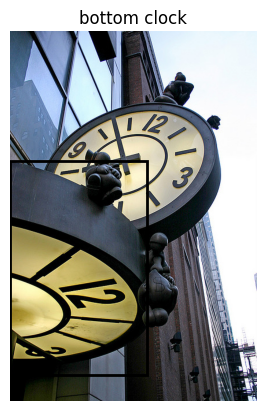

Correct SPATIAL_ONLY


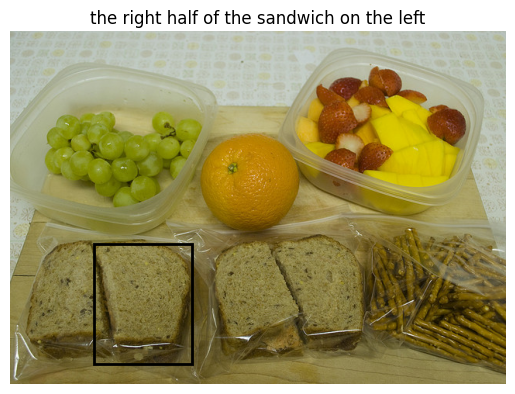

Incorrect ATTRIBUTE_ONLY


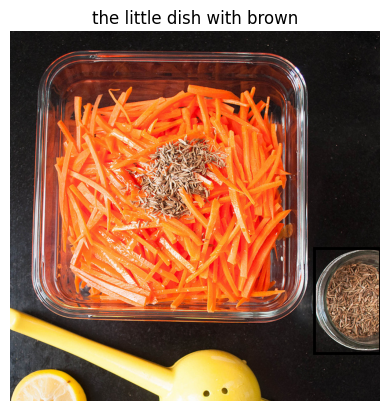

Correct ATTRIBUTE_ONLY


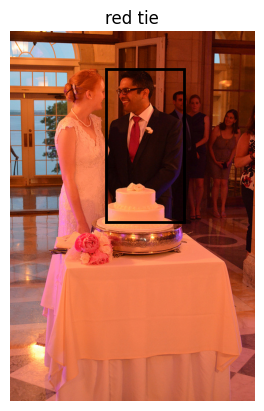

In [ ]:
import matplotlib.pyplot as plt

def show_example(row):
    image_id = row["image_id"]
    phrase = row["phrase"]
    bbox = row["bbox"]  # [x_min, y_min, x_max, y_max]

    for ex in ref_val:
        if ex["image_id"] == image_id and ex["phrase"] == phrase:
            img = ex["image"]
            fig, ax = plt.subplots()
            ax.imshow(img)
            x1, y1, x2, y2 = bbox
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 fill=False, linewidth=2)
            ax.add_patch(rect)
            ax.set_title(phrase)
            plt.axis("off")
            plt.show()
            return
    print("Could not find example")

# take one incorrect SPATIAL_ONLY example
row_bad_spatial = sample_examples(df_val_pos, "SPATIAL_ONLY", False, n=2).iloc[0]
print("Incorrect SPATIAL_ONLY")
show_example(row_bad_spatial)
# take one incorrect SPATIAL_ONLY example
row_good_spatial = sample_examples(df_val_pos, "SPATIAL_ONLY", True, n=2).iloc[0]
print("Correct SPATIAL_ONLY")
show_example(row_good_spatial)

# one incorrect attribute example
row_bad_attr = sample_examples(df_val_pos, "ATTRIBUTE_ONLY", False, n=2).iloc[0]
print("Incorrect ATTRIBUTE_ONLY")
show_example(row_bad_attr)
# and one correct ATTRIBUTE_ONLY example
row_good_attr = sample_examples(df_val_pos, "ATTRIBUTE_ONLY", True, n=2).iloc[0]
print("Correct ATTRIBUTE_ONLY")
show_example(row_good_attr)


In [24]:
df_val_pos[["image_id", "phrase", "example_type", "pred_full", "correct_full"]].head()


,image_id,phrase,example_type,pred_full,correct_full
0,217799,elephant in foreground,pos,0,False
3,217799,left elephant,pos,0,False
6,122916,kid,pos,1,True
9,122916,boy in gray clothes,pos,0,False
12,101369,man in middle,pos,1,True


Plot:
1. Baseline accuracy by phrase type

2. Influence comparison (baseline vs drop_spatial vs drop_attribute)

In [ ]:
summary_df = pd.DataFrame({
    "baseline": baseline_by_type,
    "drop_spatial": spatial_drop_by_type,
    "drop_attribute": attr_drop_by_type,
}).T # transpose so rows = condition

1. **Plot: baseline accuracy by phrase type**

This is a simple one-bar-per-phrase-type chart.

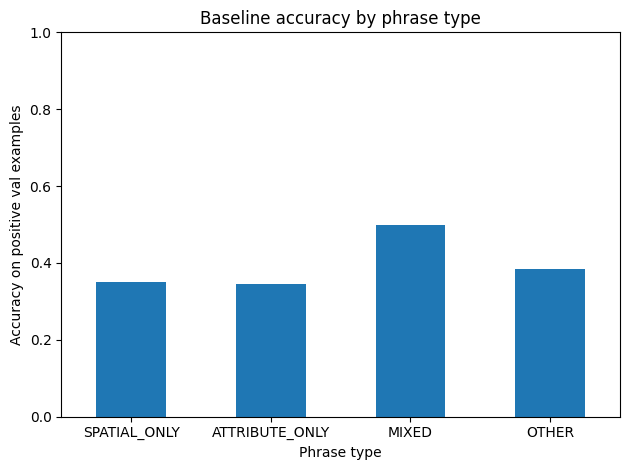

In [ ]:
import matplotlib.pyplot as plt

baseline_by_type = summary_df.loc["baseline"]

plt.figure()
baseline_by_type.plot(kind="bar")
plt.xlabel("Phrase type")
plt.ylabel("Accuracy on positive val examples")
plt.title("Baseline accuracy by phrase type")
plt.xticks(rotation=0)
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()


2. **Plot: influence comparison across conditions**

<Figure size 640x480 with 0 Axes>

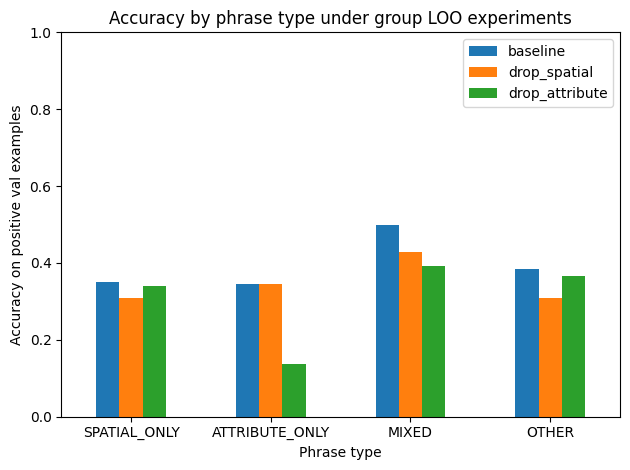

In [27]:
plt.figure()
summary_df.T.plot(kind="bar")  # transpose: now rows = phrase types
plt.xlabel("Phrase type")
plt.ylabel("Accuracy on positive val examples")
plt.title("Accuracy by phrase type under group LOO experiments")
plt.xticks(rotation=0)
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()


Save the results to a .csv file

In [28]:
import os

os.makedirs("data", exist_ok=True)  # optional, in case data/ doesn't exist yet
summary_df.to_csv("data/phrase_type_accuracy_summary.csv", index=True)
baseline_by_type.to_csv("data/baseline_phrase_type_accuracy.csv", header=["accuracy"])

